In [2]:
import os
import matplotlib.pyplot as plt

# List the contents of the extracted dataset directory to confirm its structure
dataset_path =  '/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb' # Path to the extracted dataset
dataset_structure = os.listdir(dataset_path)

# Organize directories for train, validation, and test splits
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

# Check subdirectories in train, valid, and test
train_contents = os.listdir(train_dir) if os.path.exists(train_dir) else []
valid_contents = os.listdir(valid_dir) if os.path.exists(valid_dir) else []
test_contents = os.listdir(test_dir) if os.path.exists(test_dir) else []

{
    "Dataset Structure": dataset_structure,
    "Train Subdirectories": train_contents,
    "Valid Subdirectories": valid_contents,
    "Test Subdirectories": test_contents,
}

{'Dataset Structure': ['README.dataset.txt',
  'README.roboflow.txt',
  'export',
  'valid',
  'test',
  'train',
  'data.yaml'],
 'Train Subdirectories': ['images', 'labels', 'labels.cache'],
 'Valid Subdirectories': ['images', 'labels', 'labels.cache'],
 'Test Subdirectories': ['labels', 'images']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Select a sample label file from the train/labels directory
train_labels_dir = os.path.join(train_dir, "labels")
sample_label_file = os.path.join(train_labels_dir, os.listdir(train_labels_dir)[0])

# Read and display the content of the sample label file
with open(sample_label_file, 'r') as file:
    sample_label_content = file.readlines()

sample_label_content
# Locate the corresponding image for the sample label file
sample_image_name = os.path.splitext(os.path.basename(sample_label_file))[0] + ".jpg"
sample_image_path = os.path.join(train_dir, "images", sample_image_name)

# Confirm the corresponding image exists
os.path.exists(sample_image_path)


True

Found non-empty label file: drawernexttobed_42_jpg.rf.21d9debbffe8dd89a829b24c53ac2af8.txt
Labels: ['15 0.0625 0.11298076923076923 0.9735576923076923 0.11298076923076923 0.9735576923076923 0.8798076923076923 0.0625 0.8798076923076923']


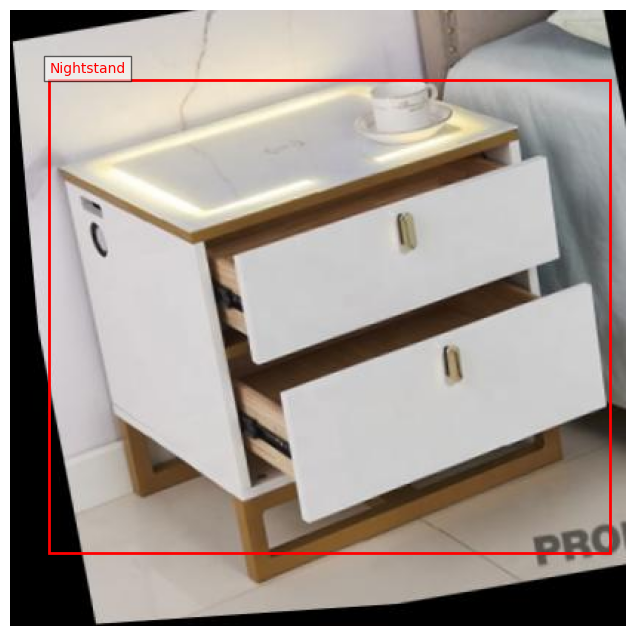

In [4]:
#  Dataset Exploration and Setup

import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Dataset paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb'
train_dir = os.path.join(dataset_path, "train")
train_labels_dir = os.path.join(train_dir, "labels")
train_images_dir = os.path.join(train_dir, "images")

# Class names from data.yaml
class_names = {
    0: "Bed", 1: "Cabinet", 2: "Carpet", 3: "Ceramic floor", 4: "Chair",
    5: "Closet", 6: "Cupboard", 7: "Curtains", 8: "Dining Table", 9: "Door",
    10: "Frame", 11: "Futec frame", 12: "Futech tiles", 13: "Gypsum Board",
    14: "Lamp", 15: "Nightstand", 16: "Shelf", 17: "Sideboard", 18: "Sofa",
    19: "TV stand", 20: "Table", 21: "Transparent Closet", 22: "Wall Panel",
    23: "Window", 24: "Wooden floor"
}

# Function to find a non-empty label file
def find_non_empty_label_file(labels_dir, images_dir):
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            labels = f.readlines()
        if labels:  # If the file is not empty
            print(f"Found non-empty label file: {label_file}")
            print("Labels:", labels)

            # Return the paths to the label and image file
            return label_path, os.path.join(images_dir, os.path.splitext(label_file)[0] + ".jpg")
    print("No label files with bounding boxes found.")
    return None, None

# Function to visualize YOLO-format bounding boxes
def visualize_oriented_bounding_boxes(image_path, label_path, class_names):
    """
    Visualize oriented bounding boxes (polygon format) on an image.
    """
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Set up the figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Read the label file
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Skip visualization if the label file is empty
    if not labels:
        print(f"No bounding boxes found for {image_path}. Skipping visualization.")
        return

    for label in labels:
        # Parse label data
        label_data = label.strip().split()
        class_id = int(label_data[0])
        polygon_coords = list(map(float, label_data[1:]))

        # Convert relative coordinates to absolute pixel values
        abs_coords = [
            (polygon_coords[i] * img_width, polygon_coords[i + 1] * img_height)
            for i in range(0, len(polygon_coords), 2)
        ]

        # Ensure the polygon is closed by appending the first point at the end
        abs_coords.append(abs_coords[0])

        # Draw the polygon
        polygon = patches.Polygon(
            abs_coords, closed=True, edgecolor='red', fill=False, linewidth=2
        )
        ax.add_patch(polygon)

        # Add class label
        ax.text(
            abs_coords[0][0],
            abs_coords[0][1] - 5,
            class_names[class_id],
            color='red',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6)
        )

    plt.axis('off')
    plt.show()

# Main Script
# Step 1: Find a non-empty label file
sample_label_file, sample_image_file = find_non_empty_label_file(train_labels_dir, train_images_dir)

# Step 2: Visualize if a valid label file is found
if sample_label_file and sample_image_file:
    visualize_oriented_bounding_boxes(sample_image_file, sample_label_file, class_names)
else:
    print("No valid labels found for visualization.")

Dataset Summary:
Number of label files:
- Train: 6405
- Valid: 890
- Test: 739


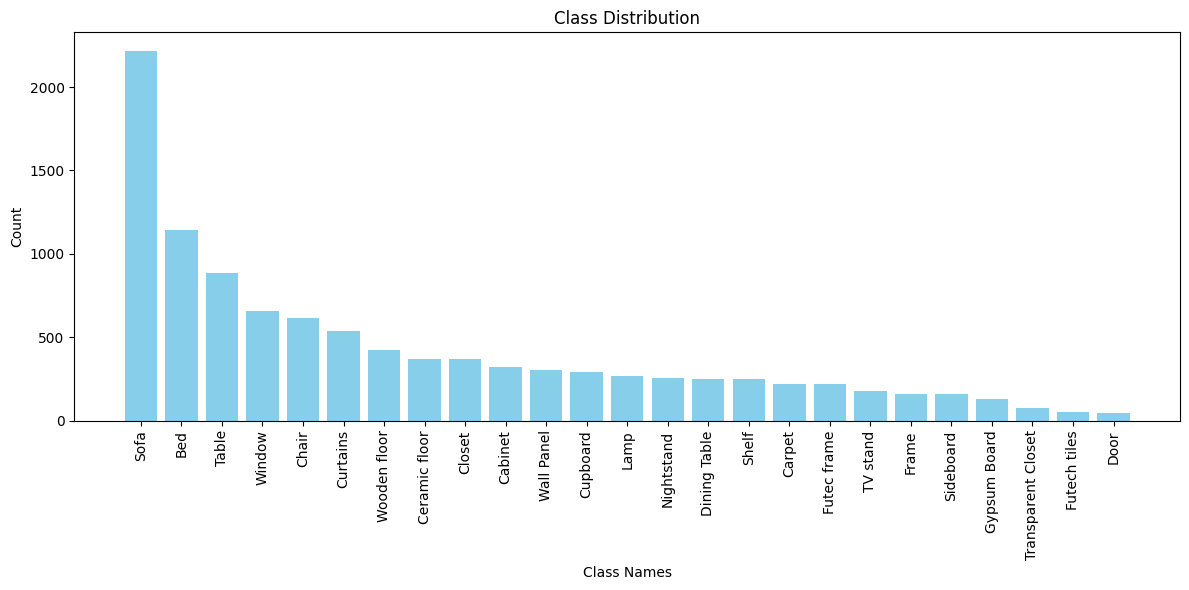

In [5]:
#  Exploratory Data Analysis
#  Dataset Summary and Class Distribution

import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Define dataset paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb'
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

train_labels_dir = os.path.join(train_dir, "labels")
valid_labels_dir = os.path.join(valid_dir, "labels")
test_labels_dir = os.path.join(test_dir, "labels")

# Define class names (adjust based on your dataset's data.yaml file)
class_names = {
    0: "Bed", 1: "Cabinet", 2: "Carpet", 3: "Ceramic floor", 4: "Chair",
    5: "Closet", 6: "Cupboard", 7: "Curtains", 8: "Dining Table", 9: "Door",
    10: "Frame", 11: "Futec frame", 12: "Futech tiles", 13: "Gypsum Board",
    14: "Lamp", 15: "Nightstand", 16: "Shelf", 17: "Sideboard", 18: "Sofa",
    19: "TV stand", 20: "Table", 21: "Transparent Closet", 22: "Wall Panel",
    23: "Window", 24: "Wooden floor"
}

# Initialize counters for class distribution and dataset splits
class_counter = Counter()
split_counts = {"train": 0, "valid": 0, "test": 0}

# Helper function to count classes in a label file
def count_classes_in_label_file(label_file_path):
    with open(label_file_path, 'r') as file:
        labels = file.readlines()
    for label in labels:
        class_id = int(label.strip().split()[0])
        class_counter[class_id] += 1

# Count labels in the train split
if os.path.exists(train_labels_dir):
    split_counts["train"] = len(os.listdir(train_labels_dir))
    for label_file in os.listdir(train_labels_dir):
        count_classes_in_label_file(os.path.join(train_labels_dir, label_file))

# Count labels in the validation split
if os.path.exists(valid_labels_dir):
    split_counts["valid"] = len(os.listdir(valid_labels_dir))
    for label_file in os.listdir(valid_labels_dir):
        count_classes_in_label_file(os.path.join(valid_labels_dir, label_file))

# Count labels in the test split
if os.path.exists(test_labels_dir):
    split_counts["test"] = len(os.listdir(test_labels_dir))
    for label_file in os.listdir(test_labels_dir):
        count_classes_in_label_file(os.path.join(test_labels_dir, label_file))

# Convert class counts to a DataFrame
class_distribution = pd.DataFrame.from_dict(class_counter, orient="index", columns=["Count"])
class_distribution.index = class_distribution.index.map(class_names.get)
class_distribution = class_distribution.sort_values(by="Count", ascending=False)

# Display dataset summary
print("Dataset Summary:")
print(f"Number of label files:")
print(f"- Train: {split_counts['train']}")
print(f"- Valid: {split_counts['valid']}")
print(f"- Test: {split_counts['test']}")

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.index, class_distribution["Count"], color="skyblue")
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

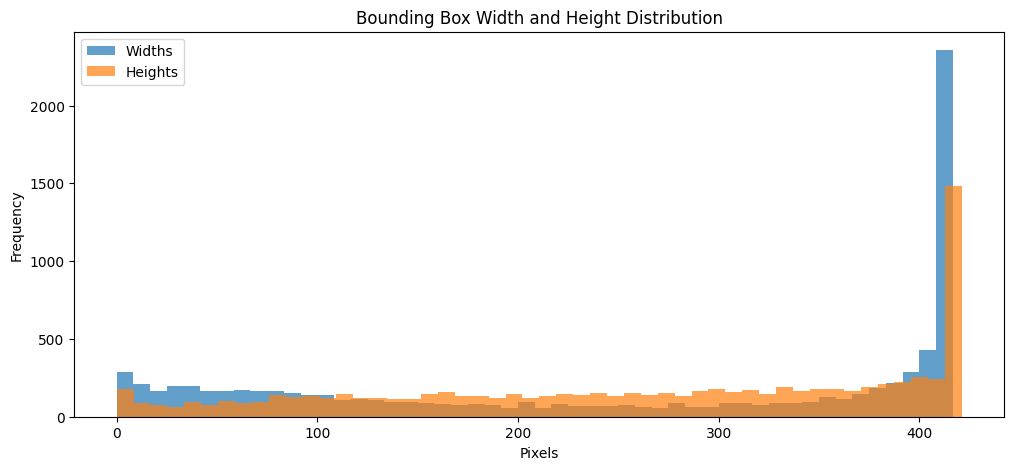

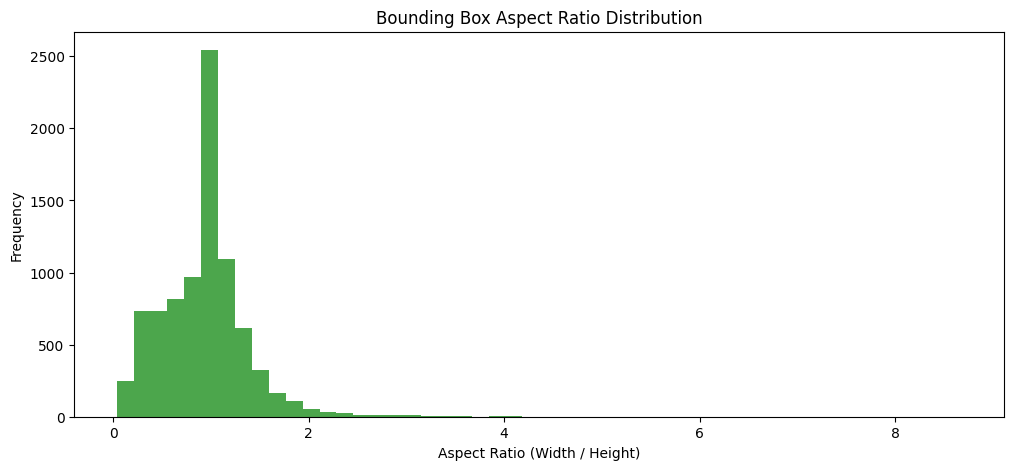

In [6]:
#  Exploratory Data Analysis
#  Bounding Box Statistics and Image Dimension

from PIL import Image  # Ensure Image is imported
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store bounding box statistics
bbox_widths = []
bbox_heights = []
aspect_ratios = []

# Helper function to calculate bounding box statistics
def analyze_bounding_boxes(label_file_path, image_width, image_height):
    with open(label_file_path, 'r') as file:
        labels = file.readlines()
    for label in labels:
        data = list(map(float, label.strip().split()[1:]))
        # Convert relative coordinates to absolute pixel values
        points = [(data[i] * image_width, data[i + 1] * image_height) for i in range(0, len(data), 2)]
        # Calculate width, height, and aspect ratio
        width = np.abs(points[1][0] - points[0][0])
        height = np.abs(points[2][1] - points[1][1])
        bbox_widths.append(width)
        bbox_heights.append(height)
        aspect_ratios.append(width / height if height > 0 else 0)

# Analyze bounding boxes in the train split
if os.path.exists(train_labels_dir):
    for label_file in os.listdir(train_labels_dir):
        image_file = os.path.join(train_dir, "images", os.path.splitext(label_file)[0] + ".jpg")
        if os.path.exists(image_file):
            image = Image.open(image_file)
            image_width, image_height = image.size
            analyze_bounding_boxes(os.path.join(train_labels_dir, label_file), image_width, image_height)

# Create histograms for bounding box statistics
plt.figure(figsize=(12, 5))
plt.hist(bbox_widths, bins=50, alpha=0.7, label="Widths")
plt.hist(bbox_heights, bins=50, alpha=0.7, label="Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Bounding Box Width and Height Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(aspect_ratios, bins=50, color="green", alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 17.0 MB/s eta 0:00:00


In [9]:
#  Steps for Training the Model and Evaluate

from ultralytics import YOLO

# Load a YOLOv8 model (pre-trained weights)
model = YOLO('yolov8n.pt')  # You can also use 'yolov8s.pt' or other variants

# Train the model
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml',
    epochs=50,         # Number of epochs to train
    batch=16,          # Batch size
    imgsz=416,         # Image size
    project='furniture_detection',  # Project folder for logs and weights
    name='yolov8_furniture',        # Experiment name
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 78.6MB/s]


Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=furniture_detection, name=yolov8_furniture, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]


Overriding model.yaml nc=80 with nc=25

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 60.8MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/labels.cache... 6405 images, 378 backgrounds, 500 corrupt: 100%|██████████| 6414/6414 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000025791666176_png.rf.507f3115d7ce92faf01f4e7408977a3c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0063]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026031667200_png.rf.6b5264bb12ed99084443d8b06537bed2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0331      1.0894]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026111666176_png.rf.2ceb47f0336953220acc73795a302114.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.041]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/labels.cache... 890 images, 66 backgrounds, 17 corrupt: 100%|██████████| 890/890 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/00000177_jpg.rf.fd9f5a7bad445bcaff37c195a3b59c67.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1293       1.129]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111049_jpg.rf.c5b88700656be2d1faa07c4a559e97d8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0415]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111262_jpg.rf.104b9ef1d0ebadc84af6912b01d11a9d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0694      1.0082]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshu

Plotting labels to furniture_detection/yolov8_furniture/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to furniture_detection/yolov8_furniture
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.09G      1.171      3.528      1.504         40        416: 100%|██████████| 370/370 [01:16<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


                   all        873        992      0.699      0.145      0.144     0.0862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.09G      1.098      2.549      1.482         42        416: 100%|██████████| 370/370 [00:35<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.94it/s]


                   all        873        992      0.446      0.277      0.259      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.07G      1.033      2.186      1.427         44        416: 100%|██████████| 370/370 [00:34<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.03it/s]

                   all        873        992      0.356      0.374      0.308      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.07G      1.002      2.033      1.389         43        416: 100%|██████████| 370/370 [00:34<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.69it/s]


                   all        873        992      0.528      0.363      0.355      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.08G     0.9779        1.9      1.367         37        416: 100%|██████████| 370/370 [00:34<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.53it/s]

                   all        873        992      0.556      0.393      0.366      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.08G     0.9568      1.807      1.345         36        416: 100%|██████████| 370/370 [00:34<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.75it/s]


                   all        873        992      0.557      0.409      0.427      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.08G     0.9344      1.735       1.33         37        416: 100%|██████████| 370/370 [00:34<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]


                   all        873        992      0.492      0.448      0.447      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.08G     0.9301      1.707      1.332         33        416: 100%|██████████| 370/370 [00:34<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.78it/s]

                   all        873        992      0.653      0.361      0.444      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.08G     0.9126      1.626      1.316         38        416: 100%|██████████| 370/370 [00:34<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.30it/s]

                   all        873        992      0.556      0.407      0.445      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.08G     0.8986      1.607      1.308         34        416: 100%|██████████| 370/370 [00:34<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.73it/s]


                   all        873        992      0.582      0.452      0.507      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.07G     0.8946      1.575      1.305         45        416: 100%|██████████| 370/370 [00:34<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.98it/s]


                   all        873        992      0.553      0.427      0.463      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.07G     0.8822      1.524      1.297         28        416: 100%|██████████| 370/370 [00:34<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


                   all        873        992      0.429      0.505      0.487       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.08G     0.8774      1.517      1.293         54        416: 100%|██████████| 370/370 [00:34<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.71it/s]


                   all        873        992       0.56      0.472      0.531      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.08G     0.8692      1.464       1.29         47        416: 100%|██████████| 370/370 [00:34<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.67it/s]

                   all        873        992      0.456      0.507      0.511      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.08G     0.8655      1.441      1.284         36        416: 100%|██████████| 370/370 [00:34<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.10it/s]


                   all        873        992      0.568      0.493      0.545      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.08G     0.8494      1.415      1.276         40        416: 100%|██████████| 370/370 [00:34<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


                   all        873        992      0.599      0.513      0.566      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.08G     0.8421      1.389      1.273         37        416: 100%|██████████| 370/370 [00:34<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


                   all        873        992      0.531      0.517      0.514      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.08G     0.8374      1.373      1.267         40        416: 100%|██████████| 370/370 [00:34<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]


                   all        873        992      0.519      0.544      0.555      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.08G     0.8362      1.363      1.268         31        416: 100%|██████████| 370/370 [00:34<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.98it/s]


                   all        873        992      0.587      0.526      0.554       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.08G     0.8233      1.335      1.258         36        416: 100%|██████████| 370/370 [00:34<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.86it/s]


                   all        873        992       0.56      0.507      0.559      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.08G     0.8203      1.334       1.26         36        416: 100%|██████████| 370/370 [00:34<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


                   all        873        992      0.591      0.565      0.589      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.09G     0.8162       1.32      1.254         34        416: 100%|██████████| 370/370 [00:34<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.53it/s]

                   all        873        992      0.576       0.54      0.545      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.08G     0.8036      1.291      1.245         39        416: 100%|██████████| 370/370 [00:34<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.82it/s]


                   all        873        992      0.589       0.54      0.578       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.08G      0.804       1.27      1.243         34        416: 100%|██████████| 370/370 [00:34<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.28it/s]


                   all        873        992      0.543      0.541      0.579      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.08G     0.8075      1.252      1.241         31        416: 100%|██████████| 370/370 [00:34<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


                   all        873        992      0.564      0.571      0.566       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.07G     0.7862      1.237      1.234         34        416: 100%|██████████| 370/370 [00:34<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.68it/s]

                   all        873        992      0.586      0.493      0.573      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.08G     0.7761      1.233       1.23         53        416: 100%|██████████| 370/370 [00:34<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.82it/s]


                   all        873        992      0.588      0.557      0.599      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.08G     0.7769      1.221      1.234         42        416: 100%|██████████| 370/370 [00:34<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.32it/s]


                   all        873        992      0.593      0.604      0.613      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.08G     0.7799      1.197       1.23         33        416: 100%|██████████| 370/370 [00:34<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.34it/s]


                   all        873        992      0.522      0.547      0.577      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.08G      0.776        1.2      1.225         33        416: 100%|██████████| 370/370 [00:34<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.98it/s]


                   all        873        992      0.593      0.556      0.586       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.07G     0.7703      1.184      1.224         38        416: 100%|██████████| 370/370 [00:34<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]

                   all        873        992      0.584      0.591      0.607      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.07G     0.7617      1.168      1.218         43        416: 100%|██████████| 370/370 [00:34<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


                   all        873        992      0.614       0.54        0.6      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.08G      0.764      1.171       1.22         39        416: 100%|██████████| 370/370 [00:34<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.97it/s]


                   all        873        992       0.61      0.575      0.602      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.08G     0.7551      1.152       1.21         32        416: 100%|██████████| 370/370 [00:34<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.94it/s]


                   all        873        992      0.601      0.591       0.62      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.08G     0.7516       1.14      1.213         44        416: 100%|██████████| 370/370 [00:34<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.70it/s]


                   all        873        992      0.568      0.603      0.616      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.07G      0.742      1.117      1.209         37        416: 100%|██████████| 370/370 [00:34<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.78it/s]

                   all        873        992      0.598      0.595      0.624      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.08G     0.7423      1.126      1.208         32        416: 100%|██████████| 370/370 [00:34<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.94it/s]

                   all        873        992      0.629      0.535      0.607      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.08G     0.7301      1.093      1.198         38        416: 100%|██████████| 370/370 [00:34<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.49it/s]


                   all        873        992      0.604      0.584      0.614      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.07G     0.7324      1.088      1.195         35        416: 100%|██████████| 370/370 [00:34<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.77it/s]


                   all        873        992      0.583      0.593       0.61      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.06G     0.7256      1.092      1.195         41        416: 100%|██████████| 370/370 [00:34<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.93it/s]

                   all        873        992      0.573      0.584      0.609      0.395


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.08G     0.6341     0.8042      1.209         13        416: 100%|██████████| 370/370 [00:34<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.72it/s]


                   all        873        992      0.582      0.579      0.612      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.08G     0.6134     0.7326        1.2         11        416: 100%|██████████| 370/370 [00:33<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.10it/s]

                   all        873        992      0.581      0.579      0.608      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.08G     0.6009     0.7119      1.189         10        416: 100%|██████████| 370/370 [00:33<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.28it/s]


                   all        873        992      0.523      0.614      0.585      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.07G     0.5898       0.69      1.184         12        416: 100%|██████████| 370/370 [00:33<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.77it/s]

                   all        873        992      0.576      0.584      0.608      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.08G     0.5827     0.6787      1.176         10        416: 100%|██████████| 370/370 [00:33<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.92it/s]


                   all        873        992      0.634        0.6      0.622      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.08G     0.5772     0.6485      1.168         14        416: 100%|██████████| 370/370 [00:34<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.71it/s]


                   all        873        992      0.615      0.586      0.618      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.08G     0.5691     0.6413      1.165         11        416: 100%|██████████| 370/370 [00:33<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.31it/s]


                   all        873        992      0.575      0.611      0.612      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.08G     0.5669     0.6336      1.159         15        416: 100%|██████████| 370/370 [00:33<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.02it/s]


                   all        873        992      0.587      0.593      0.617      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.08G     0.5613     0.6282       1.16         21        416: 100%|██████████| 370/370 [00:33<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.31it/s]


                   all        873        992       0.63      0.565      0.607        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.08G     0.5548     0.6163      1.151         13        416: 100%|██████████| 370/370 [00:33<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.04it/s]


                   all        873        992      0.584      0.582      0.602      0.398

50 epochs completed in 0.550 hours.
Optimizer stripped from furniture_detection/yolov8_furniture/weights/last.pt, 6.2MB
Optimizer stripped from furniture_detection/yolov8_furniture/weights/best.pt, 6.2MB

Validating furniture_detection/yolov8_furniture/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,010,523 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.68it/s]


                   all        873        992      0.597      0.597      0.624      0.413
                   Bed         69         69      0.823      0.928      0.947      0.687
               Cabinet         46         55      0.577       0.57       0.62      0.403
                Carpet         12         14       0.54      0.214      0.205      0.173
         Ceramic floor          5          7     0.0756      0.143     0.0694       0.04
                 Chair         66         76      0.764      0.803      0.863      0.544
                Closet         30         31      0.655      0.903      0.887      0.727
              Cupboard         22         23      0.684      0.696      0.777      0.569
              Curtains         18         21       0.53      0.476       0.54      0.384
          Dining Table         37         37      0.926       0.68      0.883      0.499
                  Door          8          9      0.507       0.23      0.291      0.168
                 Fram

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a09e1bbf490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,  


image 1/1 /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/test/images/202-244-19_jpg.rf.79de8d0f51542d3a742f3dbafbd09074.jpg: 416x416 1 Sofa, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict


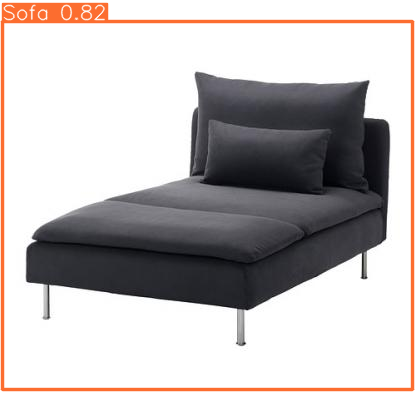

In [10]:
#  Make Predictions - Use the trained model to detect furniture in test images

# Load the trained model
model = YOLO('/content/furniture_detection/yolov8_furniture/weights/best.pt')

# Predict on a test image
results = model.predict(source='/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/test/images/202-244-19_jpg.rf.79de8d0f51542d3a742f3dbafbd09074.jpg', save=True)

# Visualize results
results[0].show()

Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=True, device=None, workers=8, project=furniture_detection, name=yolov8_furniture2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/labels.cache... 6405 images, 378 backgrounds, 500 corrupt: 100%|██████████| 6414/6414 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000025791666176_png.rf.507f3115d7ce92faf01f4e7408977a3c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0063]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026031667200_png.rf.6b5264bb12ed99084443d8b06537bed2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0331      1.0894]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026111666176_png.rf.2ceb47f0336953220acc73795a302114.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.041]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 


train: Caching images (2.9GB RAM): 100%|██████████| 5914/5914 [01:26<00:00, 68.39it/s] 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/labels.cache... 890 images, 66 backgrounds, 17 corrupt: 100%|██████████| 890/890 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/00000177_jpg.rf.fd9f5a7bad445bcaff37c195a3b59c67.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1293       1.129]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111049_jpg.rf.c5b88700656be2d1faa07c4a559e97d8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0415]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111262_jpg.rf.104b9ef1d0ebadc84af6912b01d11a9d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0694      1.0082]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshu

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.4GB RAM): 100%|██████████| 873/873 [00:02<00:00, 320.34it/s]


Plotting labels to furniture_detection/yolov8_furniture2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to furniture_detection/yolov8_furniture2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.1G      1.297      3.455      1.557         34        416: 100%|██████████| 370/370 [00:35<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.10it/s]


                   all        873        992      0.546      0.138       0.11     0.0633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.03G      1.079      2.132      1.423         44        416: 100%|██████████| 370/370 [00:32<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.11it/s]


                   all        873        992      0.534      0.151      0.136     0.0659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.04G     0.9717      1.739       1.34         40        416: 100%|██████████| 370/370 [00:30<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.49it/s]


                   all        873        992       0.26       0.22      0.164     0.0886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.04G     0.8905      1.521      1.275         28        416: 100%|██████████| 370/370 [00:30<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.80it/s]


                   all        873        992      0.459      0.247      0.233      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.07G     0.8485      1.387      1.241         39        416: 100%|██████████| 370/370 [00:30<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.89it/s]


                   all        873        992      0.378      0.241      0.216      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.04G     0.7996      1.268      1.206         32        416: 100%|██████████| 370/370 [00:30<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.84it/s]


                   all        873        992      0.361      0.332      0.256       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.04G     0.7621      1.184       1.18         40        416: 100%|██████████| 370/370 [00:30<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


                   all        873        992      0.388       0.27      0.247      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.04G     0.7326      1.141      1.165         44        416: 100%|██████████| 370/370 [00:30<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.78it/s]


                   all        873        992      0.372      0.314      0.269      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.09G     0.7142      1.086      1.151         41        416: 100%|██████████| 370/370 [00:30<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.93it/s]


                   all        873        992      0.385        0.3      0.258      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.04G     0.6893       1.04      1.135         28        416: 100%|██████████| 370/370 [00:30<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.85it/s]


                   all        873        992      0.383       0.34      0.303      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.04G     0.6716     0.9932      1.127         44        416: 100%|██████████| 370/370 [00:30<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.92it/s]


                   all        873        992       0.35      0.361      0.308      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.04G     0.6561     0.9631      1.116         36        416: 100%|██████████| 370/370 [00:30<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.68it/s]


                   all        873        992      0.348      0.395      0.288      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.04G      0.639     0.9381      1.107         46        416: 100%|██████████| 370/370 [00:30<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.14it/s]


                   all        873        992      0.329      0.336      0.288      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.09G     0.6239     0.9092      1.101         39        416: 100%|██████████| 370/370 [00:30<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.87it/s]


                   all        873        992      0.363      0.368      0.343      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.04G      0.616     0.8837      1.097         38        416: 100%|██████████| 370/370 [00:30<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.90it/s]


                   all        873        992      0.392      0.356      0.319       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.08G     0.6094     0.8653       1.09         31        416: 100%|██████████| 370/370 [00:30<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.96it/s]


                   all        873        992      0.396      0.353      0.323      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.04G     0.5977     0.8428      1.086         54        416: 100%|██████████| 370/370 [00:30<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.97it/s]


                   all        873        992      0.362      0.428      0.328      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.04G     0.5803     0.8202      1.079         34        416: 100%|██████████| 370/370 [00:30<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.67it/s]


                   all        873        992      0.389      0.387      0.346      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.04G     0.5778     0.8106      1.077         25        416: 100%|██████████| 370/370 [00:29<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.84it/s]


                   all        873        992      0.413      0.377      0.359      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.08G     0.5625      0.781      1.066         38        416: 100%|██████████| 370/370 [00:30<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.79it/s]

                   all        873        992      0.348      0.381      0.319      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.04G     0.5617     0.7851      1.067         29        416: 100%|██████████| 370/370 [00:30<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.98it/s]


                   all        873        992      0.372      0.398      0.357      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.04G     0.5488     0.7645       1.06         37        416: 100%|██████████| 370/370 [00:31<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.86it/s]


                   all        873        992      0.428      0.409      0.368      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.08G     0.5401     0.7429      1.055         28        416: 100%|██████████| 370/370 [00:30<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.55it/s]


                   all        873        992      0.405       0.39      0.372      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.04G     0.5405     0.7425      1.055         36        416: 100%|██████████| 370/370 [00:30<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.85it/s]


                   all        873        992      0.396      0.424      0.378      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.08G     0.5324     0.7309       1.05         24        416: 100%|██████████| 370/370 [00:30<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.88it/s]


                   all        873        992      0.384      0.403      0.368      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.08G     0.5194     0.7163      1.046         37        416: 100%|██████████| 370/370 [00:30<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.13it/s]


                   all        873        992      0.429      0.422        0.4      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.04G     0.5233     0.7165       1.05         45        416: 100%|██████████| 370/370 [00:30<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.76it/s]


                   all        873        992      0.423       0.43      0.399      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.04G     0.5114     0.6983      1.045         34        416: 100%|██████████| 370/370 [00:30<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.73it/s]


                   all        873        992      0.393      0.374      0.362      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.04G     0.5092     0.6894      1.042         35        416: 100%|██████████| 370/370 [00:30<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.09it/s]


                   all        873        992      0.408      0.458      0.386      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.09G     0.5027     0.6814      1.037         36        416: 100%|██████████| 370/370 [00:30<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.09it/s]


                   all        873        992      0.501      0.405      0.411      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.03G     0.4954     0.6665      1.034         34        416: 100%|██████████| 370/370 [00:30<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.78it/s]


                   all        873        992      0.418      0.375      0.375      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.04G     0.4932     0.6642      1.032         52        416: 100%|██████████| 370/370 [00:30<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.98it/s]


                   all        873        992      0.471      0.374      0.372      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.03G     0.4849     0.6525      1.029         39        416: 100%|██████████| 370/370 [00:30<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.86it/s]


                   all        873        992      0.462      0.389      0.394      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.08G     0.4818     0.6418      1.029         34        416: 100%|██████████| 370/370 [00:30<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.03it/s]


                   all        873        992      0.394      0.433      0.413      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.04G     0.4795     0.6417      1.028         41        416: 100%|██████████| 370/370 [00:30<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.76it/s]

                   all        873        992      0.449      0.443      0.424      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.04G     0.4711      0.625      1.027         32        416: 100%|██████████| 370/370 [00:30<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.98it/s]


                   all        873        992      0.505      0.409      0.431      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.07G     0.4654     0.6218      1.021         41        416: 100%|██████████| 370/370 [00:30<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.12it/s]


                   all        873        992       0.48      0.392      0.415       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.04G     0.4599     0.6052      1.019         36        416: 100%|██████████| 370/370 [00:30<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.07it/s]


                   all        873        992      0.444       0.44      0.427      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.04G     0.4602     0.6115      1.016         33        416: 100%|██████████| 370/370 [00:30<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.88it/s]


                   all        873        992      0.537      0.393      0.444      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.04G     0.4506     0.6012      1.017         39        416: 100%|██████████| 370/370 [00:29<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.95it/s]


                   all        873        992       0.47      0.413      0.421      0.251
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.08G     0.7913      1.167      1.349         13        416: 100%|██████████| 370/370 [00:30<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.70it/s]


                   all        873        992      0.536       0.45      0.471      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.08G     0.7495      1.047      1.313         11        416: 100%|██████████| 370/370 [00:30<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.04it/s]


                   all        873        992      0.443      0.448      0.475      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.07G     0.7247      0.993      1.288         10        416: 100%|██████████| 370/370 [00:30<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.79it/s]


                   all        873        992      0.543      0.465       0.49      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.09G     0.7071     0.9469      1.277         12        416: 100%|██████████| 370/370 [00:30<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.65it/s]


                   all        873        992      0.459      0.522      0.501      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.07G     0.6968     0.9273      1.264         10        416: 100%|██████████| 370/370 [00:30<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.10it/s]


                   all        873        992      0.575      0.438      0.502      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.08G      0.686     0.8838      1.255         14        416: 100%|██████████| 370/370 [00:30<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.66it/s]


                   all        873        992       0.58      0.458      0.513       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.07G     0.6735     0.8679      1.245         11        416: 100%|██████████| 370/370 [00:30<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.74it/s]


                   all        873        992      0.447      0.495      0.513      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.08G      0.674     0.8647      1.245         15        416: 100%|██████████| 370/370 [00:29<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.48it/s]


                   all        873        992       0.45      0.539      0.508      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.08G     0.6646     0.8459      1.239         21        416: 100%|██████████| 370/370 [00:30<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.01it/s]


                   all        873        992      0.492      0.508      0.511      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.08G     0.6544     0.8195      1.228         13        416: 100%|██████████| 370/370 [00:31<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  9.06it/s]


                   all        873        992      0.506      0.484      0.505      0.317

50 epochs completed in 0.490 hours.
Optimizer stripped from furniture_detection/yolov8_furniture2/weights/last.pt, 6.2MB
Optimizer stripped from furniture_detection/yolov8_furniture2/weights/best.pt, 6.2MB

Validating furniture_detection/yolov8_furniture2/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,010,523 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.61it/s]


                   all        873        992      0.489      0.509       0.51      0.325
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to furniture_detection/yolov8_furniture2
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,010,523 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/labels.cache... 890 images, 66 backgrounds, 17 corrupt: 100%|██████████| 890/890 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/00000177_jpg.rf.fd9f5a7bad445bcaff37c195a3b59c67.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1293       1.129]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111049_jpg.rf.c5b88700656be2d1faa07c4a559e97d8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0415]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111262_jpg.rf.104b9ef1d0ebadc84af6912b01d11a9d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0694      1.0082]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshu

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.4GB RAM): 100%|██████████| 873/873 [00:02<00:00, 335.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:04<00:00, 12.97it/s]


                   all        873        992      0.486       0.51      0.511      0.325
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to furniture_detection/yolov8_furniture22
Validation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a09e15ad2a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023

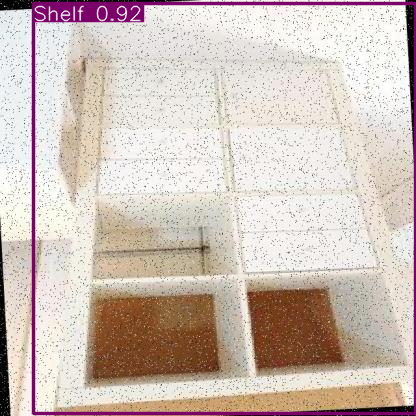

In [11]:
#  Fine-tuning for Pre-trained YOLOv8n model

from ultralytics import YOLO
import warnings

# Suppress Python warnings
warnings.filterwarnings("ignore")

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Fine-tune the model
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml',
    epochs=50,         # Number of epochs
    batch=16,          # Batch size
    imgsz=416,         # Image size
    project='furniture_detection',  # Project folder for logs and weights
    name='yolov8_furniture',        # Experiment name
    pretrained=True,   # Fine-tuning with pre-trained weights
    cache=True,
    verbose=False
)

# Validate the model after training
metrics = model.val()
print("Validation Metrics:", metrics)

# Test on a new image
test_image_path = '/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/test/images/000360_jpg.rf.d7f944b1abdf19d780e24d6a0270eb10.jpg'
results = model.predict(source=test_image_path, save=True)

# Display predictions
results[0].show()

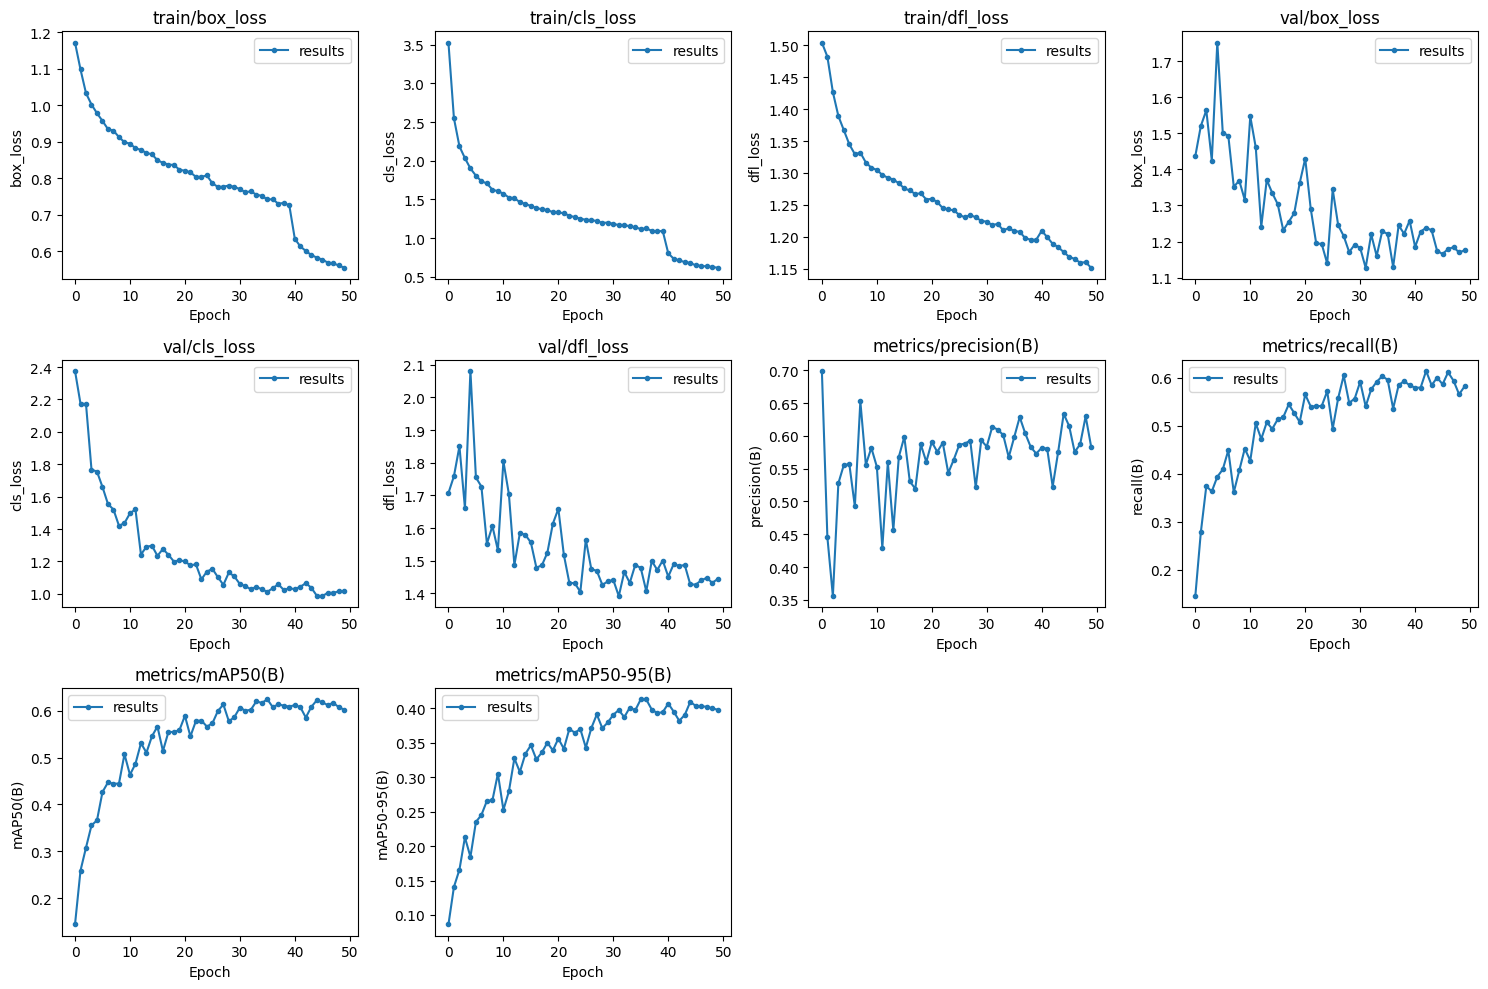

In [13]:
#  Plotting the Training and Validation Loss Metrics for YOLOv8n model

import pandas as pd
import matplotlib.pyplot as plt
import os

# Set the path to your YOLOv8 results directory
results_dir = '/content/furniture_detection/yolov8_furniture/'

# Construct the path to the results.csv file
results_csv_path = os.path.join(results_dir, 'results.csv')

# Load the results from the CSV file using pandas
results = pd.read_csv(results_csv_path)

# Define the metrics to plot
metrics = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss',
           'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)',
           'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

# Create subplots for each metric
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 4, i)
    # Access the metric data using the column name
    plt.plot(results[metric], label='results', marker='o', markersize=3)
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.split('/')[-1])
    plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Fine-tuning for Pre-trained YOLOv8s model

from ultralytics import YOLO

# Load the YOLOv8n pre-trained model
model = YOLO('yolov8n.pt')

# Train the model on your dataset
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml',  # Path to data.yaml
    epochs=50,  # Number of epochs
    batch=16,   # Batch size
    imgsz=416,  # Image size
    project='furniture_detection',  # Project folder
    name='yolov8_fine_tuned',  # Experiment name
    device=0   # Specify GPU (set to 0 for first GPU, -1 for CPU)
)

Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=furniture_detection, name=yolov8_fine_tuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/labels.cache... 6405 images, 378 backgrounds, 500 corrupt: 100%|██████████| 6414/6414 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000025791666176_png.rf.507f3115d7ce92faf01f4e7408977a3c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0063]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026031667200_png.rf.6b5264bb12ed99084443d8b06537bed2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0331      1.0894]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/train/images/0000000026111666176_png.rf.2ceb47f0336953220acc73795a302114.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.041]
train: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 


val: Scanning /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/labels.cache... 890 images, 66 backgrounds, 17 corrupt: 100%|██████████| 890/890 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/00000177_jpg.rf.fd9f5a7bad445bcaff37c195a3b59c67.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1293       1.129]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111049_jpg.rf.c5b88700656be2d1faa07c4a559e97d8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0415]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/valid/images/111262_jpg.rf.104b9ef1d0ebadc84af6912b01d11a9d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0694      1.0082]
val: WARNING ⚠️ /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshu

Plotting labels to furniture_detection/yolov8_fine_tuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to furniture_detection/yolov8_fine_tuned
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.05G      1.171      3.528      1.504         40        416: 100%|██████████| 370/370 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]


                   all        873        992      0.699      0.145      0.144     0.0862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.09G      1.098      2.549      1.482         42        416: 100%|██████████| 370/370 [00:36<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.08it/s]

                   all        873        992      0.446      0.277      0.259      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.09G      1.033      2.186      1.427         44        416: 100%|██████████| 370/370 [00:35<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


                   all        873        992      0.356      0.374      0.308      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.09G      1.002      2.033      1.389         43        416: 100%|██████████| 370/370 [00:35<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.16it/s]


                   all        873        992      0.528      0.363      0.355      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.09G     0.9779        1.9      1.367         37        416: 100%|██████████| 370/370 [00:35<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.33it/s]

                   all        873        992      0.556      0.393      0.366      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.09G     0.9568      1.807      1.345         36        416: 100%|██████████| 370/370 [00:36<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]

                   all        873        992      0.557      0.409      0.427      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.09G     0.9344      1.735       1.33         37        416: 100%|██████████| 370/370 [00:35<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.55it/s]

                   all        873        992      0.492      0.448      0.447      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.09G     0.9301      1.707      1.332         33        416: 100%|██████████| 370/370 [00:35<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.76it/s]


                   all        873        992      0.653      0.361      0.444      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.08G     0.9126      1.626      1.316         38        416: 100%|██████████| 370/370 [00:35<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.93it/s]


                   all        873        992      0.556      0.407      0.445      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.09G     0.8986      1.607      1.308         34        416: 100%|██████████| 370/370 [00:35<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.90it/s]


                   all        873        992      0.582      0.452      0.507      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.08G     0.8946      1.575      1.305         45        416: 100%|██████████| 370/370 [00:35<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.38it/s]

                   all        873        992      0.553      0.427      0.463      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.09G     0.8822      1.524      1.297         28        416: 100%|██████████| 370/370 [00:36<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]


                   all        873        992      0.429      0.505      0.487       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.08G     0.8774      1.517      1.293         54        416: 100%|██████████| 370/370 [00:35<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.56it/s]

                   all        873        992       0.56      0.472      0.531      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.09G     0.8692      1.464       1.29         47        416: 100%|██████████| 370/370 [00:35<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.32it/s]

                   all        873        992      0.456      0.507      0.511      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.09G     0.8655      1.441      1.284         36        416: 100%|██████████| 370/370 [00:35<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.32it/s]

                   all        873        992      0.568      0.493      0.545      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.09G     0.8494      1.415      1.276         40        416: 100%|██████████| 370/370 [00:35<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.30it/s]

                   all        873        992      0.599      0.513      0.566      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.08G     0.8421      1.389      1.273         37        416: 100%|██████████| 370/370 [00:35<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.78it/s]

                   all        873        992      0.531      0.517      0.514      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.09G     0.8374      1.373      1.267         40        416: 100%|██████████| 370/370 [00:36<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.80it/s]

                   all        873        992      0.519      0.544      0.555      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.09G     0.8362      1.363      1.268         31        416: 100%|██████████| 370/370 [00:35<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.15it/s]

                   all        873        992      0.587      0.526      0.554       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.09G     0.8233      1.335      1.258         36        416: 100%|██████████| 370/370 [00:35<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.05it/s]


                   all        873        992       0.56      0.507      0.559      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.08G     0.8203      1.334       1.26         36        416: 100%|██████████| 370/370 [00:35<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.72it/s]


                   all        873        992      0.591      0.565      0.589      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.08G     0.8162       1.32      1.254         34        416: 100%|██████████| 370/370 [00:35<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.70it/s]


                   all        873        992      0.576       0.54      0.545      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.09G     0.8036      1.291      1.245         39        416: 100%|██████████| 370/370 [00:35<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.52it/s]

                   all        873        992      0.589       0.54      0.578       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.09G      0.804       1.27      1.243         34        416: 100%|██████████| 370/370 [00:36<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.90it/s]


                   all        873        992      0.543      0.541      0.579      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.09G     0.8075      1.252      1.241         31        416: 100%|██████████| 370/370 [00:35<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]

                   all        873        992      0.564      0.571      0.566       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.09G     0.7862      1.237      1.234         34        416: 100%|██████████| 370/370 [00:35<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.43it/s]

                   all        873        992      0.586      0.493      0.573      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.08G     0.7761      1.233       1.23         53        416: 100%|██████████| 370/370 [00:35<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]

                   all        873        992      0.588      0.557      0.599      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.09G     0.7769      1.221      1.234         42        416: 100%|██████████| 370/370 [00:35<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.80it/s]

                   all        873        992      0.593      0.604      0.613      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.09G     0.7799      1.197       1.23         33        416: 100%|██████████| 370/370 [00:35<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.12it/s]


                   all        873        992      0.522      0.547      0.577      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.09G      0.776        1.2      1.225         33        416: 100%|██████████| 370/370 [00:36<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.89it/s]


                   all        873        992      0.593      0.556      0.586       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.08G     0.7703      1.184      1.224         38        416: 100%|██████████| 370/370 [00:35<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.71it/s]


                   all        873        992      0.584      0.591      0.607      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.09G     0.7617      1.168      1.218         43        416: 100%|██████████| 370/370 [00:35<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.83it/s]


                   all        873        992      0.614       0.54        0.6      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.09G      0.764      1.171       1.22         39        416: 100%|██████████| 370/370 [00:35<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.96it/s]

                   all        873        992       0.61      0.575      0.602      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.09G     0.7551      1.152       1.21         32        416: 100%|██████████| 370/370 [00:35<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.68it/s]

                   all        873        992      0.601      0.591       0.62      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.09G     0.7516       1.14      1.213         44        416: 100%|██████████| 370/370 [00:35<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.74it/s]

                   all        873        992      0.568      0.603      0.616      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.09G      0.742      1.117      1.209         37        416: 100%|██████████| 370/370 [00:36<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.60it/s]

                   all        873        992      0.598      0.595      0.624      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.09G     0.7423      1.126      1.208         32        416: 100%|██████████| 370/370 [00:35<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.56it/s]

                   all        873        992      0.629      0.535      0.607      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.09G     0.7301      1.093      1.198         38        416: 100%|██████████| 370/370 [00:35<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.06it/s]


                   all        873        992      0.604      0.584      0.614      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.08G     0.7324      1.088      1.195         35        416: 100%|██████████| 370/370 [00:35<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.18it/s]

                   all        873        992      0.583      0.593       0.61      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.08G     0.7256      1.092      1.195         41        416: 100%|██████████| 370/370 [00:35<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  8.14it/s]


                   all        873        992      0.573      0.584      0.609      0.395
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.09G     0.6341     0.8042      1.209         13        416: 100%|██████████| 370/370 [00:36<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.35it/s]


                   all        873        992      0.582      0.579      0.612      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.08G     0.6134     0.7326        1.2         11        416: 100%|██████████| 370/370 [00:35<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.84it/s]


                   all        873        992      0.581      0.579      0.608      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.08G     0.6009     0.7119      1.189         10        416: 100%|██████████| 370/370 [00:34<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.82it/s]


                   all        873        992      0.523      0.614      0.585      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.08G     0.5898       0.69      1.184         12        416: 100%|██████████| 370/370 [00:34<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.31it/s]


                   all        873        992      0.576      0.584      0.608      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.08G     0.5827     0.6787      1.176         10        416: 100%|██████████| 370/370 [00:34<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.52it/s]

                   all        873        992      0.634        0.6      0.622      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.09G     0.5772     0.6485      1.168         14        416: 100%|██████████| 370/370 [00:34<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.72it/s]

                   all        873        992      0.615      0.586      0.618      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.08G     0.5691     0.6413      1.165         11        416: 100%|██████████| 370/370 [00:35<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.22it/s]

                   all        873        992      0.575      0.611      0.612      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.09G     0.5669     0.6336      1.159         15        416: 100%|██████████| 370/370 [00:35<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.82it/s]


                   all        873        992      0.587      0.593      0.617      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.09G     0.5613     0.6282       1.16         21        416: 100%|██████████| 370/370 [00:34<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.97it/s]


                   all        873        992       0.63      0.565      0.607        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.09G     0.5548     0.6163      1.151         13        416: 100%|██████████| 370/370 [00:35<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:03<00:00,  7.74it/s]


                   all        873        992      0.584      0.582      0.602      0.398

50 epochs completed in 0.559 hours.
Optimizer stripped from furniture_detection/yolov8_fine_tuned/weights/last.pt, 6.2MB
Optimizer stripped from furniture_detection/yolov8_fine_tuned/weights/best.pt, 6.2MB

Validating furniture_detection/yolov8_fine_tuned/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,010,523 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:04<00:00,  6.76it/s]


                   all        873        992      0.597      0.597      0.624      0.413
                   Bed         69         69      0.823      0.928      0.947      0.687
               Cabinet         46         55      0.577       0.57       0.62      0.403
                Carpet         12         14       0.54      0.214      0.205      0.173
         Ceramic floor          5          7     0.0756      0.143     0.0694       0.04
                 Chair         66         76      0.764      0.803      0.863      0.544
                Closet         30         31      0.655      0.903      0.887      0.727
              Cupboard         22         23      0.684      0.696      0.777      0.569
              Curtains         18         21       0.53      0.476       0.54      0.384
          Dining Table         37         37      0.926       0.68      0.883      0.499
                  Door          8          9      0.507       0.23      0.291      0.168
                 Fram

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0c28861900>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,  

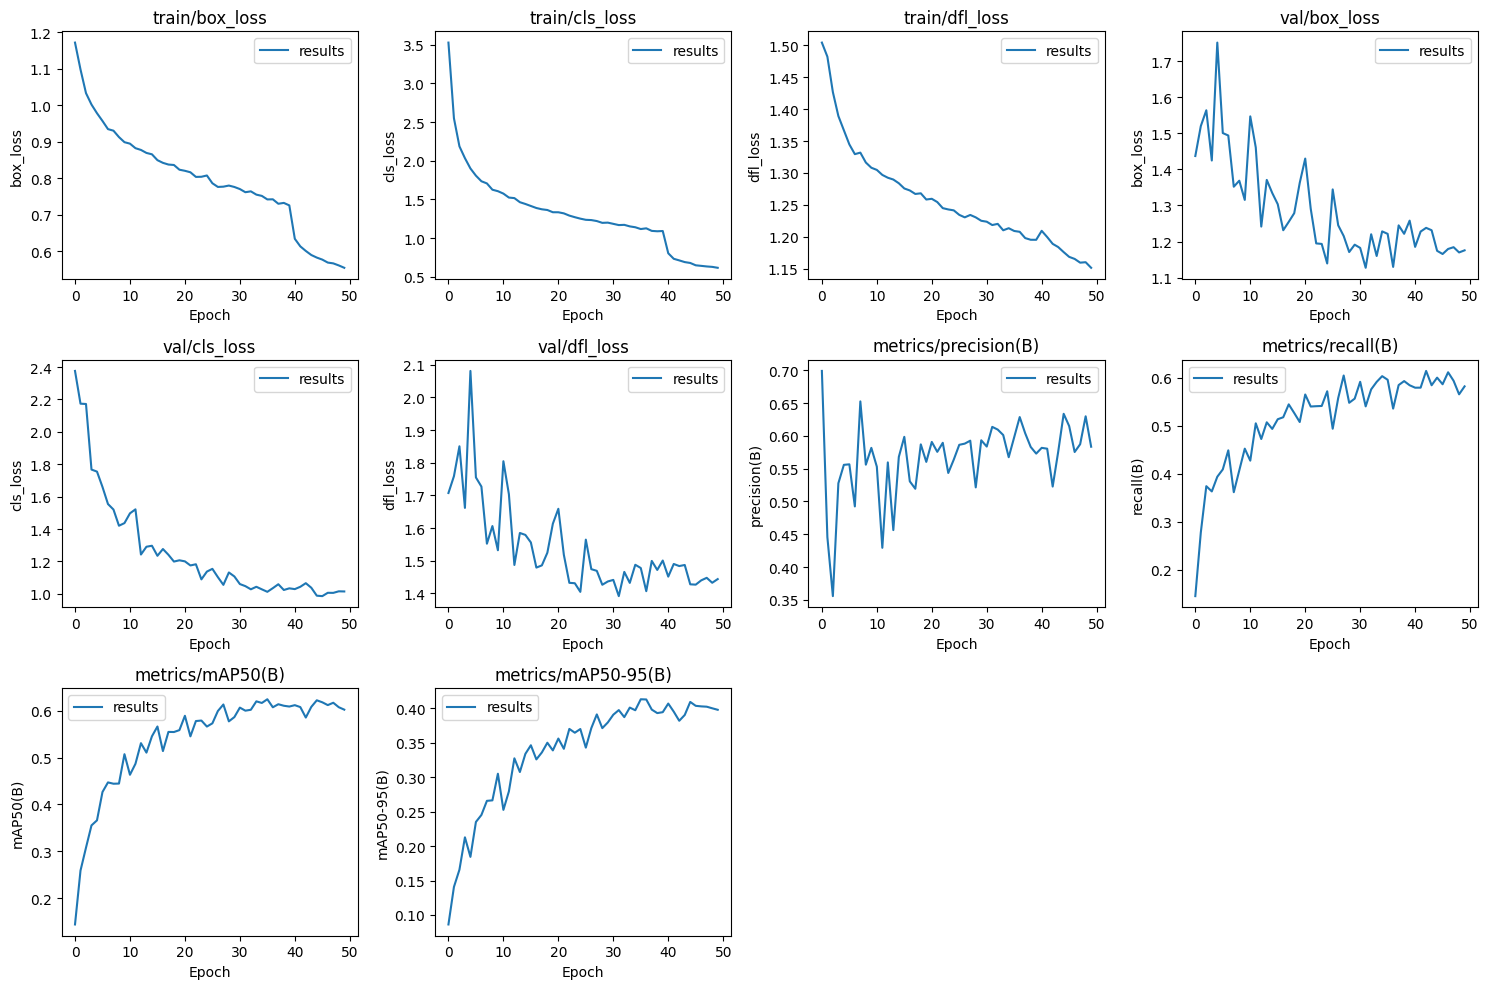

In [15]:
#  Plotting the visualization for training and validation loss for YOLOvbs model

import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv
results_csv_path = '/content/furniture_detection/yolov8_fine_tuned/results.csv'

# Load the results into a DataFrame
results = pd.read_csv(results_csv_path)

# Define the metrics to plot
metrics = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss',
           'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)',
           'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

# Plot each metric
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(3, 4, i+1)
    plt.plot(results[metric], label='results')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.split('/')[1])
    plt.legend()
plt.tight_layout()
plt.show()

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/test/images/147_jpg.rf.2d54e1832cef5af97af74c2db22254b3.jpg: 416x416 1 Table, 1 Window, 1 Wooden floor, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict4


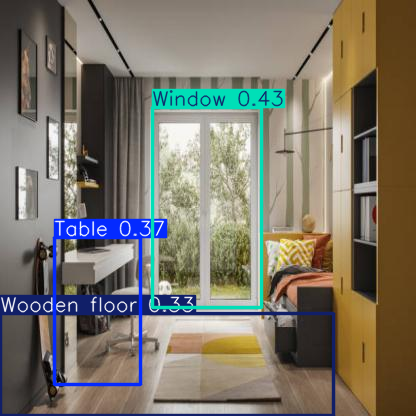

In [18]:
#  Qualitative Predictions: Visualize a few test images with bounding boxes predicted by the fine-tuned model:

from ultralytics import YOLO

# Load the fine-tuned model
model = YOLO('/content/furniture_detection/yolov8_fine_tuned/weights/best.pt')

# Predict on a sample test image
test_image_path = '/content/drive/MyDrive/Colab Notebooks/AAI 521 Computer Vision - USD/Fengshui-AI Project/furniture detection.v20i.yolov8-obb/test/images/147_jpg.rf.2d54e1832cef5af97af74c2db22254b3.jpg'
results = model.predict(source=test_image_path, save=True, show=True)

# Show results
results[0].show()  # Visualize the predictions